# Demo

Notebook to demo DBS-Pro analysis workflow. First setup and install the conda environment as specified in the [README](https://github.com/FrickTobias/DBS-Pro/blob/master/README.md).

## Run analysis
1. Download testdata

In [1]:
%%bash
wget https://export.uppmax.uu.se/uppstore2018173/DBS-Pro-testdata-0.3.tar.gz
tar xf DBS-Pro-testdata-0.3.tar.gz
ln -s DBS-Pro-testdata-0.3 testdata

--2021-07-05 16:51:06--  https://export.uppmax.uu.se/uppstore2018173/DBS-Pro-testdata-0.3.tar.gz
Resolving export.uppmax.uu.se (export.uppmax.uu.se)... 89.44.248.44
Connecting to export.uppmax.uu.se (export.uppmax.uu.se)|89.44.248.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4624771 (4.4M) [application/x-gzip]
Saving to: ‘DBS-Pro-testdata-0.3.tar.gz’

     0K .......... .......... .......... .......... ..........  1% 8.96M 0s
    50K .......... .......... .......... .......... ..........  2% 27.5M 0s
   100K .......... .......... .......... .......... ..........  3% 45.8M 0s
   150K .......... .......... .......... .......... ..........  4% 67.1M 0s
   200K .......... .......... .......... .......... ..........  5% 18.1M 0s
   250K .......... .......... .......... .......... ..........  6% 25.1M 0s
   300K .......... .......... .......... .......... ..........  7% 18.2M 0s
   350K .......... .......... .......... .......... ..........  8% 17.8M 0s
   400

2. Create sample CSV and initialize analysis directory

In [2]:
%%bash
echo "testdata/reads-10k-DBS.fastq.gz,sample" > samples.csv
dbspro init --abc testdata/ABC-sequences.fasta --sample-csv samples.csv analysis

SETTINGS FOR: init
 directory: analysis
 reads: []
 sample_csv: samples.csv
 abc: testdata/ABC-sequences.fasta
2021-07-05 16:51:15 - init - INFO: File reads-10k-DBS.fastq.gz given sample name 'sample'
2021-07-05 16:51:15 - init - INFO: Directory analysis initialized.
2021-07-05 16:51:15 - init - INFO: Edit analysis/dbspro.yaml and run 'cd analysis && dbspro run' to start the analysis.


In [3]:
%cd analysis/

/Users/pontus.hojer/projects/DBS-Pro/example/analysis


In [4]:
%ls

ABC-sequences.fasta  sample.fastq.gz@
dbspro.yaml          samples.tsv


3. View current configs

In [5]:
%%bash
dbspro config

--- CONFIGS IN: dbspro.yaml ---
############
# Trimming #
############
dbs: BDVHBDVHBDVHBDVHBDVH # IUPAC string for DBS sequence
dbs_len_span: 1 # Span (+/-) relative DBS_len for accepted DBS i.e for 1 the span is DBS_len-1 to DBS_len+1 bp.
umi_len: 6 # Length in basepairs of UMI sequence
abc_umi_len_span: 0 # Span (+/-) relative the sum of the ABC and UMI lengths
trim_err_rate: 0.2 # Error rate for handle trimming.

# Handels
h1: CGATGCTAATCAGATCA # h1 adaptor sequence, appears before droplet barcode
h2: AAGAGTCAATAGACCATCTAACAGGATTCAGGTA # h2 adaptor sequence, appears after droplet barcode
h3: TTATATCACGACAAGAG # h3 adaptor sequence, appears after Ab-barcode and UMI

##################
# Demultiplexing #
##################
abc_file: ABC-sequences.fasta    # Fasta file containing target information.
demultiplex_err_rate: 0.2 # Error rate for demultiplexing ABC sequences..

####################
# Pipeline configs #
####################
dbs_cluster_dist: 2 # Maximum edit distance to clu

4. Update configs. Here we set the trim error rate to 0.1. 

In [6]:
%%bash
dbspro config --set trim_err_rate 0.1

SETTINGS FOR: config
 set: [['trim_err_rate', '0.1']]
 file: dbspro.yaml
 print_construct: False
 construct: None
2021-07-05 16:51:18 - config - INFO: Changing value of 'trim_err_rate': 0.2 --> 0.1.


5. Run pipeline

In [7]:
%%bash
dbspro run

SETTINGS FOR: run
 targets: []
 dryrun: False
 cores: 16
 keepgoing: False
 delete_all_output: False
 force_run: None
 unlock: False
 dir: None
 dag: False
 filegraph: False
Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 16
Rules claiming more threads will be scaled down.
Job counts:
	count	jobs
	3	abc_cluster
	1	all
	1	analyze
	1	correct_dbs
	1	dbs_cluster
	1	demultiplex_abc
	1	extract_abc_umi
	1	extract_dbs
	1	make_report
	1	merge_data
	12

[Mon Jul  5 16:51:19 2021]
rule extract_dbs:
    input: sample.fastq.gz
    output: sample.dbs-raw.fastq.gz
    log: log_files/sample.cutadapt-extract-dbs.log
    jobid: 8
    wildcards: sample=sample
    threads: 16

cutadapt -g ^CGATGCTAATCAGATCA...AAGAGTCAATAGACCATCTAACAGGATTCAGGTA --discard-untrimmed -e 0.1 -m 19 -M 21 -j 16 -o sample.dbs-raw.fastq.gz sample.fastq.gz > log_files/sample.cutadapt-extract-dbs.log
[Mon Jul  5 16:51:20 2021]
Finished job 8.
1 of 12 steps (8%) done

[Mon Jul  5 16:51:20 2021]
rule extract_abc_umi:
  

In [8]:
%ls

ABC-sequences.fasta            sample.data.tsv.gz
ABCs/                          sample.dbs-clusters.txt.gz
data.tsv.gz                    sample.dbs-corrected.fasta.gz
dbspro.yaml                    sample.dbs-raw.fastq.gz
log_files/                     sample.fastq.gz@
report.html                    sample.trimmed-abc.fastq.gz
report.ipynb                   samples.tsv


## Load and analyse data

1. Load dataframe

In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

dtypes = {
    "Barcode": "object",
    "Target": "object",
    "UMI": "object",
    "ReadCount": np.int,
    "Sample": "category"
}
data_long = pd.read_csv("data.tsv.gz", sep="\t", dtype=dtypes)
data_long.head()

,Barcode,Target,UMI,ReadCount,Sample
0,CAAACAAACGCATTCTCTAC,ABC2,AACGGA,1,sample
1,CAAACAAACGCATTCTCTAC,ABC2,ACAGGG,2,sample
2,CAAACAAACGCATTCTCTAC,ABC2,ACGCGT,1,sample
3,CAAACAAACGCATTCTCTAC,ABC2,ACGGGC,1,sample
4,CAAACAAACGCATTCTCTAC,ABC2,AGATAC,1,sample


In [10]:
labels = list(set(data_long["Sample"]))
labels.sort(reverse=True)
print(f"labels = {labels}")

targets = ["ABC1", "ABC2", "ABC3"]  # Can load from file
print(f"targets = {targets}")

labels = ['sample']
targets = ['ABC1', 'ABC2', 'ABC3']


2. QC on data. Here we plot the UMI count distribution as an example. 

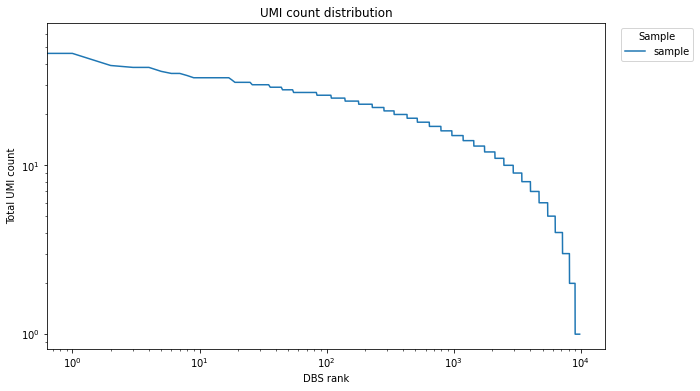

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("UMI count distribution")
for label in labels:
    temp = data_long[data_long["Sample"] == label].groupby("Barcode", as_index=False)["UMI"].count().sort_values(by="UMI",ascending=False).reset_index(drop=True)
    try:
        temp.plot(ax=ax, y="UMI", logx=True, logy=True, label=label)
    except TypeError:
        pass
    
ax.set_xlabel("DBS rank")
ax.set_ylabel("Total UMI count")
_ = plt.legend(bbox_to_anchor=(1.02, 1), title="Sample", loc='upper left')

3. Filter data and transform into wide (matrix) format. Here we filter out barcodes with only one UMI. When converting to matrix we also attach some useful qc data for each barcode using `qc=True`.

In [12]:
from dbspro.notebook import filter_uc, to_matrix

data_wide = (data_long.pipe(filter_uc, 1)
                      .pipe(to_matrix, qc=True))
data_wide.head()

Filtering barcodes by total UMI count gt 1
Barcodes = 9,003 (-787, -8.04%, runtime:0.020092248916625977 s)


Target,ABC1,ABC2,ABC3,total_count,nr_targets,total_reads
Barcode,,,,,,
CAAACAAACGCATTCTCTAC,0.0,18.0,0.0,18.0,1,19
CAAACAACTAACTGACCGGT,0.0,7.0,0.0,7.0,1,11
CAAACACATAGTTAATTTGA,0.0,4.0,0.0,4.0,1,8
CAAACACTGTAAGAATTTAC,0.0,6.0,0.0,6.0,1,7
CAAACAGTGTCACGGCTTAC,0.0,2.0,0.0,2.0,1,7


4. Normalize data.  

In [13]:
data_norm = data_wide.copy()
data_norm.loc[:,targets] = data_norm.loc[:,targets].apply(np.log1p)

5. Plot data

Install [sklearn](https://scikit-learn.org/stable/index.html) to plot PCA.

In [14]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit_transform(data_norm.loc[:,targets].apply(np.log1p))
data_norm["pca1"] = pca[:,0]
data_norm["pca2"] = pca[:,1]

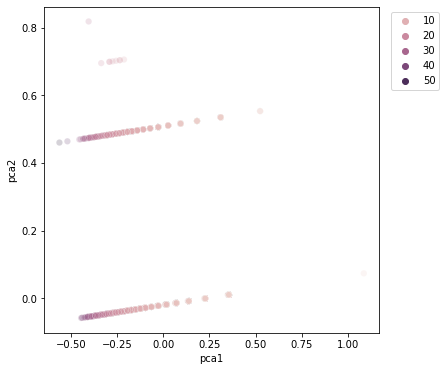

In [16]:
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.scatterplot(data=data_norm, x="pca1", y="pca2", hue="total_count",
                     s=40, alpha=0.2, ax=ax)
_ = plt.legend(bbox_to_anchor=(1.02, 1), title="", loc='upper left')